![image](https://github.com/eWaterCycle/ewatercycle/raw/main/docs/examples/logo.png)

# Running Wflow using the ewatercycle system

This notebooks shows how to run [Wflow](https://wflow.readthedocs.io/en/latest/) model using an example use-case. More information about data, configuration and installation instructions can be found in the [System setup](https://ewatercycle.readthedocs.io/en/latest/system_setup.html) chapter in the eWaterCycle documentation.

In [1]:
import logging
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
logging.basicConfig(level=logging.WARN)

In [ ]:
from rich import print

import ewatercycle.forcing
import ewatercycle.models
import ewatercycle.parameter_sets

## Setting up the model

The model needs a parameter set and forcing. The parameter set can be gotten from the available parameters sets on the system and the forcing can derived from the parameter set.

In [3]:
parameter_set = ewatercycle.parameter_sets.available_parameter_sets()[
    "wflow_rhine_sbm_nc"
]
print(parameter_set)

ParameterSet(
    name='wflow_rhine_sbm_nc',
    directory=PosixPath('/home/bart/ewatercycle/parameter-sets/wflow_rhine_sbm_nc'),
    config=PosixPath('/home/bart/ewatercycle/parameter-sets/wflow_rhine_sbm_nc/wflow_sbm_NC.ini'),
    doi='N/A',
    target_model='wflow',
    supported_model_versions={'2020.1.1', '2020.1.3', '2020.1.2'},
    downloader=GitHubDownloader(
        org='openstreams',
        repo='wflow',
        branch='master',
        subfolder='examples/wflow_rhine_sbm_nc'
    )
)

In [4]:
forcing = ewatercycle.forcing.sources["WflowForcing"](
    directory=str(parameter_set.directory),
    start_time="1991-01-01T00:00:00Z",
    end_time="1991-12-31T00:00:00Z",
    # Additional information about the external forcing data needed for the model configuration
    netcdfinput="inmaps.nc",
    Precipitation="/P",
    EvapoTranspiration="/PET",
    Temperature="/TEMP",
)
print(forcing)

WflowForcing(
    start_time='1991-01-01T00:00:00Z',
    end_time='1991-12-31T00:00:00Z',
    directory=PosixPath('/home/bart/ewatercycle/parameter-sets/wflow_rhine_sbm_nc'),
    shape=None,
    netcdfinput='inmaps.nc',
    Precipitation='/P',
    EvapoTranspiration='/PET',
    Temperature='/TEMP',
    Inflow=None
)

## Set up the model

To create the model object, we provide it with the forcing and parameter set objects:

In [5]:
model = ewatercycle.models.Wflow(
    parameter_set=parameter_set, forcing=forcing
)
print(model)

Wflow(
    parameter_set=ParameterSet(
        name='wflow_rhine_sbm_nc',
        directory=PosixPath('/home/bart/ewatercycle/parameter-sets/wflow_rhine_sbm_nc'),
        config=PosixPath('/home/bart/ewatercycle/parameter-sets/wflow_rhine_sbm_nc/wflow_sbm_NC.ini'),
        doi='N/A',
        target_model='wflow',
        supported_model_versions={'2020.1.1', '2020.1.3', '2020.1.2'},
        downloader=GitHubDownloader(
            org='openstreams',
            repo='wflow',
            branch='master',
            subfolder='examples/wflow_rhine_sbm_nc'
        )
    ),
    forcing=WflowForcing(
        start_time='1991-01-01T00:00:00Z',
        end_time='1991-12-31T00:00:00Z',
        directory=PosixPath('/home/bart/ewatercycle/parameter-sets/wflow_rhine_sbm_nc'),
        shape=None,
        netcdfinput='inmaps.nc',
        Precipitation='/P',
        EvapoTranspiration='/PET',
        Temperature='/TEMP',
        Inflow=None
    )
)

Each model also has a version. This version is retrieved from the BMI container image.

To run a different version of the model, you can specify the container image:
```py
from ewatercycle.container import ContainerImage

ewatercycle.models.Wflow(
    forcing=forcing,
    bmi_image=ContainerImage("ewatercycle/ewatercycle/wflow-grpc4bmi:2020.1.3")  # Modify the tag (`2020.1.3`) for a different version.
)
```

To view the model's version, do:

In [6]:
model.version

'2020.1.3'

The pre-configured parameters are shown below and can be overwritten with `setup()`

In [7]:
model.parameters

dict_items([('start_time', '1991-01-01T00:00:00Z'), ('end_time', '1991-12-31T00:00:00Z')])

Before we can run the model, we have to set it up. For this you do:

In [8]:
cfg_file, cfg_dir = model.setup(end_time="1991-02-28T00:00:00Z")

In [10]:
print(cfg_file)
print(cfg_dir)

/home/bart/ewatercycle/output/wflow_20231129_134611/wflow_ewatercycle.ini

/home/bart/ewatercycle/output/wflow_20231129_134611

The config file can be edited, but for now we will initialize the model with the config file as is

In [11]:
model.initialize(cfg_file)

## Running the model

In [ ]:
while model.time < model.end_time:
    model.update()
    print(model.time_as_isostr)

## Inspect the results

The RiverRunnoff values of the current model state can be fetched as a [xarray dataset](http://xarray.pydata.org/en/stable/user-guide/data-structures.html#dataset).

In [13]:
da = model.get_value_as_xarray("RiverRunoff")
da

<xarray.DataArray 'RiverRunoff' (time: 1, latitude: 169, longitude: 187)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float64 5.227 5.264 5.3 5.337 ... 11.97 12.01 12.05
  * latitude   (latitude) float64 45.89 45.93 45.97 46.0 ... 51.98 52.02 52.05
  * time       (time) datetime64[ns] 1991-02-28
Attributes:
    units:     m/s

In [14]:
print(da)

<xarray.DataArray 'RiverRunoff' (time: 1, latitude: 169, longitude: 187)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float64 5.227 5.264 5.3 5.337 ... 11.97 12.01 12.05
  * latitude   (latitude) float64 45.89 45.93 45.97 46.0 ... 51.98 52.02 52.05
  * time       (time) datetime64[ns] 1991-02-28
Attributes:
    units:     m/s

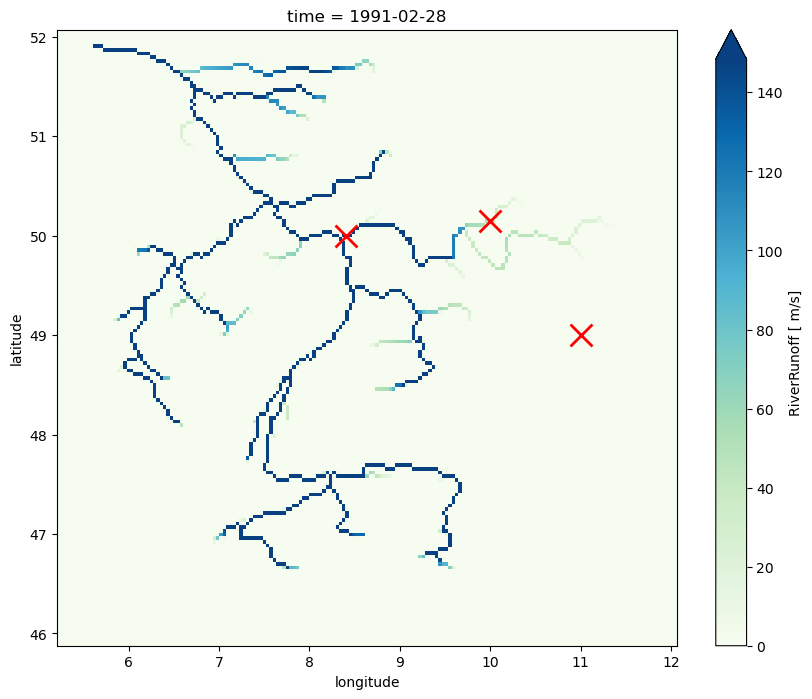

In [15]:
qm = da.plot(robust=True, cmap="GnBu", figsize=(10, 8))

# Add some verification points
target_longitudes = [8.4, 10, 11]
target_latitudes = [50, 50.15, 49]
# Add some crosses to check that 'get_value_at_coords' works correctly below
qm.axes.scatter(target_longitudes, target_latitudes, s=250, c="r", marker="x", lw=2)

Instead of getting the whole spatial grid, you can also get RiverRunoff values at some coordinates (red crosses in above plot).

In [16]:
model.get_value_at_coords("RiverRunoff", lon=target_longitudes, lat=target_latitudes)

array([200.49532 ,  44.607876,   0.      ], dtype=float32)

We are done with the model so let's clean it up.

In [17]:
model.finalize()